In [2]:
# Nguyen Hai Duong
# nhduong_3010@live.com
# Chonnam National University
# 2018.01.21

# Overview
- MNIST dataset
  + Goal: estimating summation of handwritten digit images
  + Input: a set of 28x28 images
  + Output: summation of given handwritten digit images
- Defining an CNN+LSTM for MNIST dataset
- Training and evaluating an CNN+LSTM

# Import libraries

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from keras.optimizers import SGD

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import time
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# (1) Data

In [4]:
# the data, shuffled and split between train and test sets
(X_train_raw, y_train_temp), (X_test_raw, y_test_temp) = mnist.load_data()

#basic image processing
X_train_raw = X_train_raw.astype('float32')
X_test_raw  = X_test_raw.astype('float32')
X_train_raw /= 255
X_test_raw  /= 255

print('X_train_raw shape:', X_train_raw.shape)
print(X_train_raw.shape[0], 'train samples')
print(X_test_raw.shape[0], 'test samples')

X_train_raw shape: (60000, 28, 28)
60000 train samples
10000 test samples


## Original data
- Input: 48x48 image
- Output: label (0, 1,..., 9)

## Data preprocessing
- Read images from MNIST
- Compute their summation

## New data
- Input: eight 48x48 images
- Output: summation of eight input images

In [5]:
n_train = X_train_raw.shape[0]
x_train = []
y_train = []

n_test = X_test_raw.shape[0]
x_test = []
y_test = []

np.random.seed(2018)
maxToAdd = 8
size = 28

x_train = np.zeros((n_train, maxToAdd, size, size, 1))

for i in range(0, n_train):
    #initialize a training example of max_num_time_steps, im_size, im_size
    output = np.zeros((maxToAdd, size, size, 1))
    #decide how many MNIST images to put in that tensor
    numToAdd = int(np.ceil(np.random.rand()*maxToAdd))
    #sample that many images
    indices = np.random.choice(X_train_raw.shape[0], size=numToAdd)
    example = X_train_raw[indices]
    #sum up the outputs for new output
    exampleY = y_train_temp[indices]
    output[0:numToAdd,:,:,0] = example
    x_train[i, :, :, :, :] = output
    y_train.append(np.sum(exampleY))

y_train = np.array(y_train)

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

# Test the model
x_test = np.zeros((n_test, maxToAdd, size, size, 1))
for i in range(0, n_test):
    output = np.zeros((maxToAdd, size, size, 1))
    numToAdd = int(np.ceil(np.random.rand()*maxToAdd))
    indices = np.random.choice(X_test_raw.shape[0], size=numToAdd)
    example = X_test_raw[indices]
    exampleY = y_test_temp[indices]
    output[0:numToAdd,:,:,0] = example
    x_test[i, :, :, :, :] = output
    y_test.append(np.sum(exampleY))

x_test = np.array(x_test)
y_test = np.array(y_test)

print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (60000, 8, 28, 28, 1)
y_train shape:  (60000,)
x_test shape:  (10000, 8, 28, 28, 1)
y_test shape:  (10000,)


# (2) Declare model

In [6]:
# 28x28 MNIST image
input_image = Input(shape=(maxToAdd, 28, 28, 1), name='Input')

# conv, pooling layers + dropout
x = TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'), name='conv1')(input_image)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name='pool1')(x)
x = TimeDistributed(Dropout(rate=0.2), name='conv_dropout1')(x)

x = TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'), name='conv2')(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name='pool2')(x)
x = TimeDistributed(Dropout(rate=0.2), name='conv_dropout2')(x)

x = TimeDistributed(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'), name='conv3')(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name='pool3')(x)
x = TimeDistributed(Dropout(rate=0.2), name='conv_dropout3')(x)

# similar to the MLP example!
# matrix ---> vector
x = TimeDistributed(Flatten(), name='flatten')(x)

# LSTM + dropout
x = LSTM(units=128, return_sequences=True, name='lstm1')(x)
x = LSTM(units=128, return_sequences=False, name='lstm2')(x)
x = Dropout(rate=0.22, name='lstm_dropout')(x)

output_label = Dense(units=1, name='fc3_10ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='mnist_mlp')

# print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 8, 28, 28, 1)      0         
_________________________________________________________________
conv1 (TimeDistributed)      (None, 8, 28, 28, 64)     640       
_________________________________________________________________
pool1 (TimeDistributed)      (None, 8, 14, 14, 64)     0         
_________________________________________________________________
conv_dropout1 (TimeDistribut (None, 8, 14, 14, 64)     0         
_________________________________________________________________
conv2 (TimeDistributed)      (None, 8, 14, 14, 128)    73856     
_________________________________________________________________
pool2 (TimeDistributed)      (None, 8, 7, 7, 128)      0         
_________________________________________________________________
conv_dropout2 (TimeDistribut (None, 8, 7, 7, 128)      0         
__________

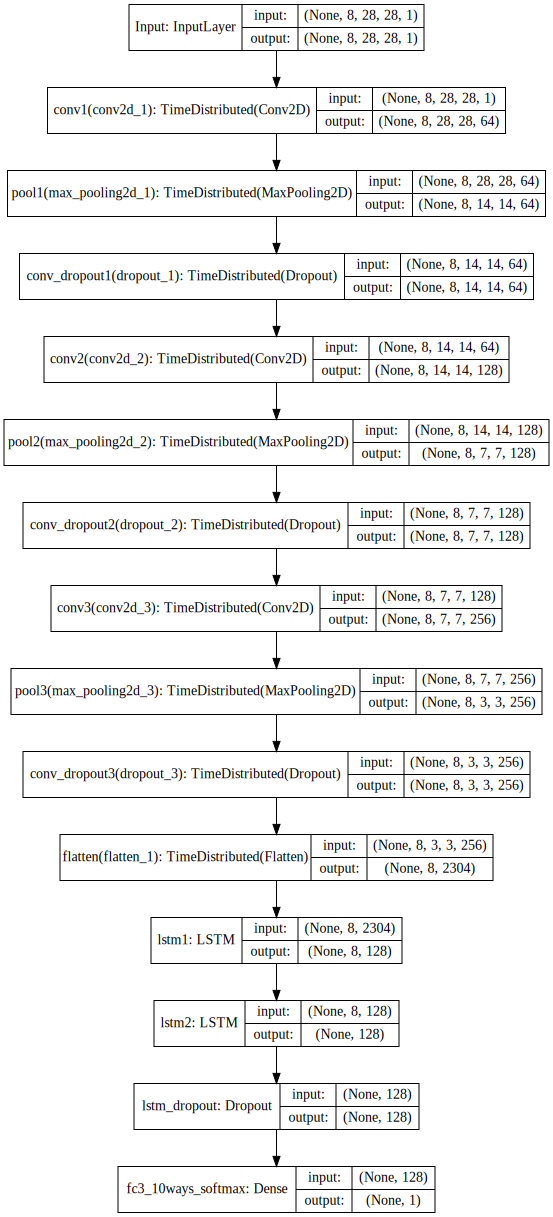

In [7]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [13]:
# declare learning rate, loss function, and model metric
loss = 'mean_absolute_error'
lr = 0.01
model.compile(loss=loss, optimizer=SGD(lr=lr))

# train the model
batch_size = 128
epochs = 30

starting_time = time.time()
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batch_size,
                    epochs=epochs)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 55s 918us/step - loss: 7.1956 - val_loss: 4.6118
Epoch 2/30
60000/60000 [==============================] - 52s 868us/step - loss: 3.8313 - val_loss: 3.3663
Epoch 3/30
60000/60000 [==============================] - 53s 878us/step - loss: 3.0295 - val_loss: 2.2807
Epoch 4/30
60000/60000 [==============================] - 52s 872us/step - loss: 2.4621 - val_loss: 1.7907
Epoch 5/30
60000/60000 [==============================] - 52s 870us/step - loss: 2.0594 - val_loss: 1.4065
Epoch 6/30
60000/60000 [==============================] - 53s 885us/step - loss: 1.8009 - val_loss: 1.2458
Epoch 7/30
60000/60000 [==============================] - 55s 913us/step - loss: 1.6705 - val_loss: 1.3729
Epoch 8/30
60000/60000 [==============================] - 55s 915us/step - loss: 1.5584 - val_loss: 1.1766
Epoch 9/30
60000/60000 [==============================] - 55s 914us/step - loss: 1.4608 - val_

### Training time
- Training time with GTX 1080 is about 26.6267 minutes for 30 epochs
- Training time with Core i7 is around 808 minutes (~13.5 hours) for 30 epochs

# (4) Evaluate trained model

In [28]:
score = model.evaluate(x_test, y_test)
print('Mean absolute error of testing set:', score)

10000/10000 [==============================] - 5s 541us/step
Mean absolute error of testing set: 0.6501955397605896


> actual summation = 33
> estimated summation = 33.035


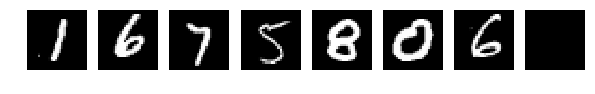

In [50]:
# select a test image randomly
random_test_index = np.random.choice(x_test.shape[0], size=1)[0]

plt.figure(figsize=(10, 5))
for indx in range(maxToAdd):
    plt.subplot(1, maxToAdd, indx + 1)
    test_img = x_test[random_test_index, indx, :, :, 0]
    plt.axis('off')
    plt.imshow(test_img, cmap='gray')

# estimate summation of testing images
est_sum = model.predict(np.expand_dims(x_test[random_test_index], axis=0))[0][0]

print('> actual summation = %d' % y_test[random_test_index])
print('> estimated summation = %.3f' % est_sum)
plt.show()